<a href="https://colab.research.google.com/github/Kreative-Karuna/Data_Science/blob/main/RFM_Analysis_Pharma_Retailers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Customer segmentation** is the practice of grouping customers based on common characteristics. These customer segments are beneficial in marketing campaigns, in identifying potentially profitable customers, and in developing customer loyalty. A company might segment customers according to a wide range of factors, including: demographics (age, gender, location etc), behaviour (previous orders, responses to messaging), psychographics (values, interests, lifestyles) etc.

**RFM (Recency-Frequency-Monetary) analysis** is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

The goal of this analysis is to identify customer segments for global retail company using RFM analysis and to understand how those groups differ from each other.



In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.cluster import KMeans
from pandas_profiling import ProfileReport

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DS Projects/Project 72/CreditAnalysis_data.csv") 

In [ ]:
data.head()

,Unnamed: 0,master_order_id,master_order_status,created,order_id,order_status,ordereditem_quantity,prod_names,ordereditem_unit_price_net,ordereditem_product_id,value,group,dist_names,retailer_names,bill_amount
0,1,25651,delivered,12/18/2017 10:41,25651,delivered,5,ProdName1,43.00,1744.0,215.00,Hyderabad,DistName1,RetailerID2,809.0
1,2,25651,delivered,12/18/2017 10:41,25651,delivered,5,ProdName2,35.54,965.0,177.70,Hyderabad,DistName1,RetailerID2,809.0
2,3,25651,delivered,12/18/2017 10:41,25651,delivered,2,ProdName3,52.80,705.0,105.60,Hyderabad,DistName3,RetailerID29,809.0
3,4,25651,delivered,12/18/2017 10:41,25651,delivered,2,ProdName4,118.28,264.0,236.56,Hyderabad,DistName1,RetailerID87,809.0
4,5,25651,delivered,12/18/2017 10:41,25651,delivered,3,ProdName5,32.22,1025.0,96.66,Hyderabad,DistName4,RetailerID118,809.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19148 entries, 0 to 19147
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  19148 non-null  int64  
 1   master_order_id             19148 non-null  int64  
 2   master_order_status         19148 non-null  object 
 3   created                     19148 non-null  object 
 4   order_id                    19148 non-null  int64  
 5   order_status                19148 non-null  object 
 6   ordereditem_quantity        19148 non-null  int64  
 7   prod_names                  19148 non-null  object 
 8   ordereditem_unit_price_net  19148 non-null  float64
 9   ordereditem_product_id      18977 non-null  float64
 10  value                       19148 non-null  float64
 11  group                       19148 non-null  object 
 12  dist_names                  19148 non-null  object 
 13  retailer_names              191

In [ ]:
data.isna().sum() # Product Id is showing 171 null values, which can be ignored as its not an important feature in RFM analysis & considering master_order_id only for Retailer identification  

Unnamed: 0                      0
master_order_id                 0
master_order_status             0
created                         0
order_id                        0
order_status                    0
ordereditem_quantity            0
prod_names                      0
ordereditem_unit_price_net      0
ordereditem_product_id        171
value                           0
group                           0
dist_names                      0
retailer_names                  0
bill_amount                     0
dtype: int64

In [ ]:
data.duplicated().sum() # there are no duplicte records

0

In [ ]:
data['created'] = pd.to_datetime(data['created'])  # converting to datetime format

In [ ]:
 data = data[~data['master_order_status'].str.startswith('r')] # removing Cancelled & Rejected from master_order_status and order_status columns
 data = data[~data['master_order_status'].str.startswith('c')]
 data = data[~data['order_status'].str.startswith('r')]
 data = data[~data['order_status'].str.startswith('c')]

In [ ]:
data['master_order_status'].unique() # checking all the statuses in the attribute

array(['delivered', 'processed', 'Partially Delivered', 'new', 'accepted',
       'shipped'], dtype=object)

In [ ]:
data['order_status'].unique() # checking all the statuses in the attribute

array(['delivered', 'processed', 'new', 'accepted', 'shipped'],
      dtype=object)

**Calculating Recency**

In [ ]:
df_recency = data.groupby(by = 'master_order_id',as_index = False)['created','dist_names', 'retailer_names'].max()
df_recency.columns = ['master_order_id','last_purchase_date','dist_names', 'retailer_names']
recent_date = df_recency['last_purchase_date'].max()
df_recency['Recency'] = df_recency['last_purchase_date'].apply(lambda x: (recent_date - x).days)
df_recency.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,master_order_id,last_purchase_date,dist_names,retailer_names,Recency
2176,28064,2018-05-04 09:02:00,DistName3,RetailerID137,213
2177,28065,2018-05-04 09:07:00,DistName8,RetailerID94,213
2178,28066,2018-05-04 09:07:00,DistName6,RetailerID95,213
2179,28067,2018-05-04 09:20:00,DistName1,RetailerID200,213
2180,28068,2018-05-04 09:25:00,DistName3,RetailerID37,213


**Calculating Frequency**

In [ ]:
df_frequency = data.drop_duplicates().groupby(by=['master_order_id'], as_index=False)['created'].count()
df_frequency.columns = ['master_order_id', 'Frequency']

**Calculating Monetary Value**

In [ ]:
df_monetary = data.groupby(by = 'master_order_id', as_index = False)['value'].sum()
df_monetary.columns = ['master_order_id', 'Monetary']

**Merging all three columns in one dataframe**

In [ ]:
df_rf = df_recency.merge(df_frequency, on='master_order_id')
df_rfm = df_rf.merge(df_monetary, on='master_order_id').drop(columns='last_purchase_date')
df_rfm.head()

,master_order_id,dist_names,retailer_names,Recency,Frequency,Monetary
0,25651,DistName7,RetailerID87,350,6,856.72
1,25652,DistName6,RetailerID77,349,4,497.52
2,25653,DistName9,RetailerID94,349,14,1475.12
3,25654,DistName3,RetailerID56,349,6,440.81
4,25655,DistName6,RetailerID68,349,7,1082.97


**Ranking Customer’s based upon their recency, frequency, and monetary score**


In [ ]:
df_rfm['R_Score'] = pd.qcut(df_rfm['Recency'], 5,[5,4,3,2,1]).astype(int)
df_rfm['F_Score'] = pd.qcut(df_rfm['Frequency'].rank(method="first"), 5,labels=[1,2,3,4,5]).astype(int)
df_rfm['M_Score'] = pd.qcut(df_rfm['Monetary'], 5,[5,4,3,2,1]).astype(int)
df_rfm.head()

,master_order_id,dist_names,retailer_names,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,25651,DistName7,RetailerID87,350,6,856.72,1,3,4
1,25652,DistName6,RetailerID77,349,4,497.52,1,2,5
2,25653,DistName9,RetailerID94,349,14,1475.12,1,5,3
3,25654,DistName3,RetailerID56,349,6,440.81,1,3,5
4,25655,DistName6,RetailerID68,349,7,1082.97,1,3,3


In [ ]:
# normalizing the rank of the customers
df_rfm['R_Rank'] = (df_rfm['R_Score']/df_rfm['R_Score'].max())*100
df_rfm['F_Rank'] = (df_rfm['F_Score']/df_rfm['F_Score'].max())*100
df_rfm['M_Rank'] = (df_rfm['M_Score']/df_rfm['M_Score'].max())*100

**Calculating RFM score**

RFM score is calculated based upon recency, frequency, monetary value normalize ranks. Based upon this score we divide our customers. Here we rate them on a scale of 5. Formula used for calculating rfm score is : 0.15*Recency score + 0.28*Frequency score + 0.57 *Monetary score

In [ ]:
df_rfm['RFM_Score'] = 0.15 * df_rfm['R_Rank'] + 0.28 * df_rfm['F_Rank'] + 0.57 * df_rfm['M_Rank']
df_rfm['RFM_Score'] *= 0.05
df_rfm = df_rfm.round(2)
df_rfm.head(7)

In [ ]:
df_rfm.shape

(2181, 13)

In [ ]:
df_KMeans = df_rfm.drop(columns = ['dist_names', 'retailer_names'])
df_KMeans.head()

,master_order_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,R_Rank,F_Rank,M_Rank,RFM_Score
0,25651,350,6,856.72,1,3,4,20.0,60.0,80.0,3.27
1,25652,349,4,497.52,1,2,5,20.0,40.0,100.0,3.56
2,25653,349,14,1475.12,1,5,3,20.0,100.0,60.0,3.26
3,25654,349,6,440.81,1,3,5,20.0,60.0,100.0,3.84
4,25655,349,7,1082.97,1,3,3,20.0,60.0,60.0,2.70


**KMeans Clustering**

Text(0, 0.5, 'total_within_SS')

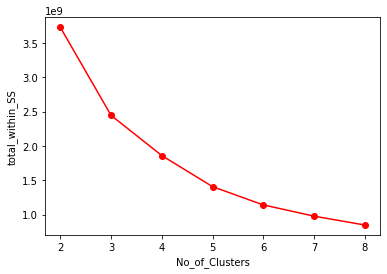

In [ ]:
TWSS = []

k = list(range(2,9))

for i in k:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df_KMeans)
    TWSS.append(kmeans.inertia_)

    
TWSS
# Scree plot 
plt.plot(k, TWSS, 'ro-');plt.xlabel("No_of_Clusters");plt.ylabel("total_within_SS")

In [ ]:
# Selecting 6 clusters from the above scree plot which is the optimum number of clusters 
model = KMeans(n_clusters = 6)
model.fit(df_KMeans)


KMeans(n_clusters=6)

In [ ]:
model.labels_ # getting the labels of clusters assigned to each row 
mb = pd.Series(model.labels_)  # converting numpy array into pandas series object 
df_rfm['Clust'] = mb # creating a  new column and assigning it to new column 
df_rfm.head() # checking 'Clust' column added to 'df_rfm' data

,master_order_id,dist_names,retailer_names,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,R_Rank,F_Rank,M_Rank,RFM_Score,Clust
0,25651,DistName7,RetailerID87,350,6,856.72,1,3,4,20.0,60.0,80.0,3.27,4
1,25652,DistName6,RetailerID77,349,4,497.52,1,2,5,20.0,40.0,100.0,3.56,4
2,25653,DistName9,RetailerID94,349,14,1475.12,1,5,3,20.0,100.0,60.0,3.26,4
3,25654,DistName3,RetailerID56,349,6,440.81,1,3,5,20.0,60.0,100.0,3.84,4
4,25655,DistName6,RetailerID68,349,7,1082.97,1,3,3,20.0,60.0,60.0,2.70,4


In [ ]:
df_rfm.Clust.value_counts() # checking count of each cluster

0    718
4    710
3    452
1    205
2     80
5     16
Name: Clust, dtype: int64

In [ ]:
df_rfm.describe().T # checking statistical dimensions of the data

,count,mean,std,min,25%,50%,75%,max
master_order_id,2181.0,26855.308116,695.683335,25651.00,26256.00,26851.00,27443.00,28068.00
Recency,2181.0,244.570381,68.516624,0.00,248.00,258.00,282.00,350.00
Frequency,2181.0,8.273269,6.968972,1.00,3.00,6.00,11.00,30.00
Monetary,2181.0,1801.274677,1847.108640,32.78,675.00,1210.05,2231.82,17057.20
R_Score,2181.0,3.036222,1.440588,1.00,2.00,3.00,4.00,5.00
F_Score,2181.0,2.999083,1.414862,1.00,2.00,3.00,4.00,5.00
M_Score,2181.0,3.000917,1.414862,1.00,2.00,3.00,4.00,5.00
R_Rank,2181.0,60.724438,28.811754,20.00,40.00,60.00,80.00,100.00
F_Rank,2181.0,59.981660,28.297237,20.00,40.00,60.00,80.00,100.00
M_Rank,2181.0,60.018340,28.297237,20.00,40.00,60.00,80.00,100.00


In [ ]:
df_rfm['RFM_Score'].groupby(df_rfm.Clust).mean() # Calculating aggregate mean of each cluster

Clust
0    3.376309
1    2.283122
2    2.324625
3    2.541372
4    3.225394
5    2.406250
Name: RFM_Score, dtype: float64

In [ ]:
df_rfm["Customer_Segment"] = np.where(df_rfm["RFM_Score"] > 4.40,"Top Customers", (np.where(df_rfm["RFM_Score"] > 4, "High Value Customers", (np.where(df_rfm["RFM_Score"] > 3, "Medium Value Customers", (np.where(df_rfm["RFM_Score"] > 2.5, "Potential-Medium Customers", (np.where(df_rfm["RFM_Score"] > 2, "Low Value Customers", "Lost Customers")))))))))

In [ ]:
df_rfm['Customer_Segment'].value_counts()

Medium Value Customers        984
Potential-Medium Customers    615
Low Value Customers           376
Lost Customers                105
High Value Customers           88
Top Customers                  13
Name: Customer_Segment, dtype: int64

In [ ]:
df_rfm.to_csv("Retail_Pharma_RFM.csv", index=False, encoding = "utf-8") # Creating csv file of the dataset with clusters column
import os
os.getcwd()

'/content'

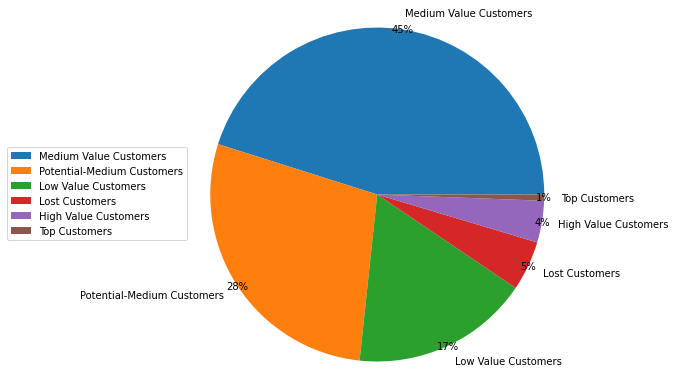

In [ ]:
plt.rcParams["figure.figsize"] = [8.00, 5.50]
plt.rcParams["figure.autolayout"] = True
plt.pie(df_rfm.Customer_Segment.value_counts(), pctdistance = 1,
        labels=df_rfm.Customer_Segment.value_counts().index,
        autopct='%.0f%%')
plt.legend(bbox_to_anchor=(0.25,0.50), loc="center right", 
                          bbox_transform=plt.gcf().transFigure),
plt.axis('equal')
plt.show()

**Sweetviz : Auto EDA**

In [ ]:
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 648 kB/s 


In [ ]:
import sweetviz as sv

my_report = sv.analyze(df_rfm)
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"


                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.7/dist-packages/sweetviz/graph.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(as_raw_bytes, format='png', transparent=True)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Pycaret : RFM Model**

In [ ]:
pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 3.9 MB/s 
     |████████████████████████████████| 3.3 MB 47.5 MB/s 
     |████████████████████████████████| 268 kB 55.5 MB/s 
     |████████████████████████████████| 1.3 MB 50.8 MB/s 
     |████████████████████████████████| 167 kB 55.7 MB/s 
     |████████████████████████████████| 25.9 MB 84.4 MB/s 
     |████████████████████████████████| 137 kB 59.3 MB/s 
     |████████████████████████████████| 88 kB 6.4 MB/s 
     |████████████████████████████████| 1.7 MB 43.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.4 MB 20.8 MB/s 
     |████████████████████████████████| 6.8 MB 45.4 MB/s 
     |████████████████████████████████| 2.0 MB 51.2 MB/s 
     |███████████████████████████████

In [ ]:
from pycaret.classification import *

In [ ]:
pip install numpy==1.20.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 47 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.0 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.
en-core-web-sm 3.4.0 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.7 which is incompatible.
cmdstanpy 1.0.7 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.


In [ ]:
df_rfm = df_rfm.iloc[:,[0,2,12,14]]
df_rfm.head()

,master_order_id,retailer_names,RFM_Score,Customer_Segment
0,25651,RetailerID87,3.27,Medium Value Customers
1,25652,RetailerID77,3.56,Medium Value Customers
2,25653,RetailerID94,3.26,Medium Value Customers
3,25654,RetailerID56,3.84,Medium Value Customers
4,25655,RetailerID68,2.70,Potential-Medium Customers


In [ ]:
data_py = df_rfm.sample(frac=0.9, random_state=42)
data_unseen = df_rfm.drop(data_py.index)

data_py.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data_py.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1963, 4)
Unseen Data For Predictions: (218, 4)


In [ ]:
df1 =  setup(data = data_py, target = 'Customer_Segment',session_id=42)

,Description,Value
0,session_id,42
1,Target,Customer_Segment
2,Target Type,Multiclass
3,Label Encoded,"High Value Customers: 0, Lost Customers: 1, Lo..."
4,Original Data,"(1963, 4)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='Customer_Segment',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                num...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'p

In [ ]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.022
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.182
lightgbm,Light Gradient Boosting Machine,0.9993,1.0000,0.9976,0.9993,0.9993,0.9989,0.9990,0.217
rf,Random Forest Classifier,0.9854,0.9999,0.8969,0.9844,0.9836,0.9786,0.9789,0.569
et,Extra Trees Classifier,0.9432,0.9942,0.8951,0.9451,0.9415,0.9163,0.9170,0.602
lda,Linear Discriminant Analysis,0.8938,0.9865,0.7753,0.9026,0.8925,0.8464,0.8496,0.049
ada,Ada Boost Classifier,0.7911,0.9121,0.6667,0.6483,0.7068,0.6776,0.7143,0.177
ridge,Ridge Classifier,0.6579,0.0000,0.3209,0.5806,0.6080,0.4577,0.4723,0.022
lr,Logistic Regression,0.4527,0.5247,0.1667,0.2050,0.2822,0.0000,0.0000,0.396
dummy,Dummy Classifier,0.4527,0.5000,0.1667,0.2050,0.2822,0.0000,0.0000,0.019


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
INFO:logs:create_model() succesfully completed......................................


In [ ]:
print(dt) # As the accuracy is very good, tuning the model is not added

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


**Plot a Model**

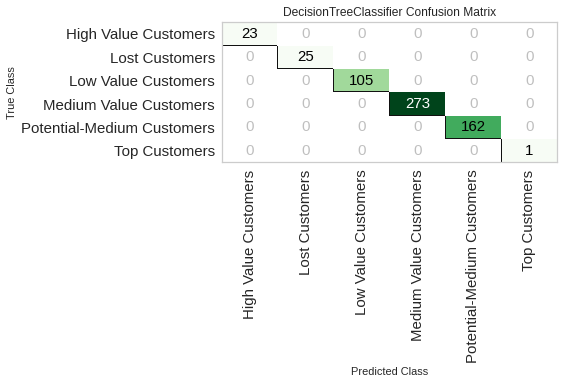

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(dt, plot = "confusion_matrix")

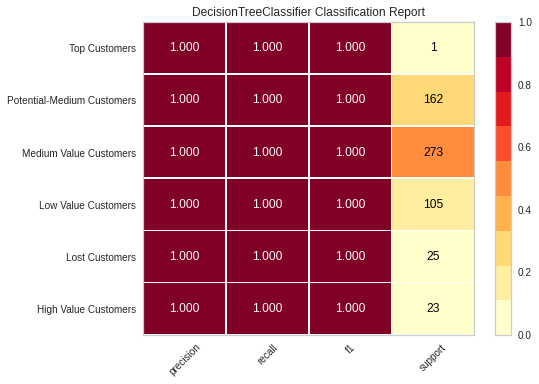

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(dt, plot = "class_report")

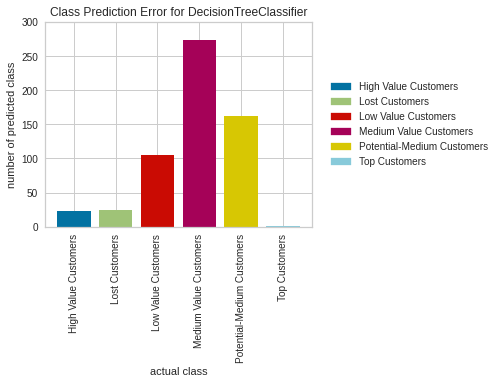

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(dt, plot = "error")

In [ ]:
predict_model(dt); # Predict on test

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
evaluate_model(dt)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**Finalize Model for Deployment**


In [ ]:
final_dt = finalize_model(dt)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='depreca

In [ ]:
print(final_dt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


**Predict on unseen data**

In [ ]:
unseen_predictions = predict_model(final_dt, data=data_unseen)
unseen_predictions.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.0,0,0,0,0,0,0


,master_order_id,retailer_names,RFM_Score,Customer_Segment,Label,Score
0,25652,RetailerID77,3.56,Medium Value Customers,Medium Value Customers,1.0
1,25677,RetailerID90,1.43,Lost Customers,Lost Customers,1.0
2,25692,RetailerID95,1.56,Lost Customers,Lost Customers,1.0
3,25724,RetailerID8,2.99,Potential-Medium Customers,Potential-Medium Customers,1.0
4,25757,RetailerID94,2.12,Low Value Customers,Low Value Customers,1.0


**Saving the model**

In [ ]:
save_model(final_dt,"final_dt")

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'), model_name=final_dt, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='Customer_Segment',
                                      time_

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Customer_Segment',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 num...
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                         criterion='gini', m

**Loading the saved model**

In [ ]:
rfm_model = load_model("final_dt")

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=final_dt, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


**Predicting on the new data**

In [ ]:
new_prediction = predict_model(rfm_model, data=data_unseen)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='Customer_Segment',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                num...
                ('dfs', 'passthrough'), ('pca', 'passthrough'),
                ['trained_model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
    

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.0,0,0,0,0,0,0


In [ ]:
new_prediction.head() # the results of unseen_predictions and new_prediction are identical


,master_order_id,retailer_names,RFM_Score,Customer_Segment,Label,Score
0,25652,RetailerID77,3.56,Medium Value Customers,Medium Value Customers,1.0
1,25677,RetailerID90,1.43,Lost Customers,Lost Customers,1.0
2,25692,RetailerID95,1.56,Lost Customers,Lost Customers,1.0
3,25724,RetailerID8,2.99,Potential-Medium Customers,Potential-Medium Customers,1.0
4,25757,RetailerID94,2.12,Low Value Customers,Low Value Customers,1.0


# **Streamlit Deployment**

In [ ]:
pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.1 MB 4.0 MB/s 
     |████████████████████████████████| 4.7 MB 46.0 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 235 kB 53.6 MB/s 
     |████████████████████████████████| 164 kB 45.3 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=953b222228927244224a631d69ac2b185b5359bf365b3e42fcdd37231012c919
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [ ]:
from pycaret.classification import load_model, predict_model
import streamlit as st
import pandas as pd
import numpy as np
model = load_model('final_dt')
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


INFO:logs:Initializing load_model()
2022-09-15 20:07:18.011 INFO    logs: Initializing load_model()
INFO:logs:load_model(model_name=final_dt, platform=None, authentication=None, verbose=True)
2022-09-15 20:07:18.020 INFO    logs: load_model(model_name=final_dt, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


In [ ]:
st.title("Customer-Segmentation based on RFM Scores for Pharma Retailers")
st.markdown('The dashboard will visualize the Customer-Segments of Pharma Retailers')
st.markdown('**RFM (Recency-Frequency-Monetary) analysis** is a simple technique for behaviour based customer segmentation')
st.sidebar.title("Visualization Selector")
st.sidebar.markdown("Select the Charts/Plots accordingly:")


  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]
2022-09-15 20:07:23.639 
  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=1, _provided_cursor=None, _parent=DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None), _block_type=None, _form_data=None)

In [ ]:
select = st.sidebar.selectbox('Visualization type', ['Bar plot', 'Pie chart'], key='1')
if not st.sidebar.checkbox("Hide", True, key='1'):
     if select == 'Pie chart':
                         st.title("Top 5 Retailers")
                         fig=px.pie(df, values=df_rfm['retailer_names'][:5], names=df_rfm['RFM_Score'][:5], title='Top 5 Retailers')
                         st.plotly_chart(fig)
                         
                         if select=='Bar plot':
                           st.title("Selected Top 5 Retailers")
                           fig = go.Figure(data=[
        go.Bar(name='Recency', x=df_rfm['reailers_names'][:5], y=df['Recency'][:5]),
        go.Bar(name='Frequency', x=df_rfm['retailer_names'][:5], y=df['Frequency'][:5]),
        go.Bar(name='Monetary', x=df_rfm['retailer_names'][:5], y=df['Monetary'][:5])])
                           st.plotly_chart(fig)


In [ ]:
def predict(model, input_df):
    predictions_df = predict_model(estimator=model, data=input_df)
    predictions = predictions_df['Label'][0]
    return predictions

In [ ]:
def run():
    from PIL import Image
    image = Image.open('Customer Lifetime Value.png')
    image_pharmacy = Image.open('Pharmacy.jpg')
    st.image(image,use_column_width=False)
    add_selectbox = st.sidebar.selectbox(
    "How would you like to predict?",
    ("Online", "Batch"))
    st.sidebar.info('This app is created to predict if an employee will leave the company')
    st.sidebar.success('https://www.pycaret.org')
    st.sidebar.image(image_pharmacy)
    st.title("Predicting Pharma Retailers Segment")
    
    if add_selectbox == 'Online':
      master_order_id =st.text_input("Enter Master Order Id")
      retailer_names =st.text_input('Enter Retailer Name')
      RFM_Score = st.text_input('RFM_Score')
      Customer_Segment=""
      input_dict={'master_order_id':master_order_id, 'retailer_names':retailer_names,'RFM_Score':RFM_Score,'Customer_Segment':Customer_Segment}
      input_df = pd.DataFrame([input_dict])
      
      if st.button("Predict"):
        Customer_Segment = predict(model=model, input_df=input_df)
        Customer_Segment = str(Customer_Segment)
        st.success('The output is {}'.format(Customer_Segment))

      if add_selectbox == 'Batch':
        file_upload = st.file_uploader("Upload csv file for predictions", type=["csv"])
        if file_upload is not None:
            data = pd.read_csv(file_upload)
            predictions = predict_model(estimator=model,data=data)
            st.write(predictions)